# 1. Dependências

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL

import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from collections import Counter
import random


# 2. Configurações e Utils

In [ ]:
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['font.size'] = 15

In [ ]:
def show_image(image, label):

  plt.imshow(image)
  plt.title(f'Label: {label}')
  plt.show()


def generate_batch(generator, batch_size, max_size=0):

  if max_size == 0:
    max_size = generator.n

  steps = max_size // batch_size
  rest = max_size % batch_size

  if rest > 0:
    steps+=1

  X = []
  Y = []

  n = 0
  for i in range(steps):
      images, labels = generator.next()
      X.extend(images)
      Y.extend(labels)

      n += batch_size
      if n > max_size:
        break

  return np.array(X)[:max_size], np.array(Y)[:max_size]


# 3. Dataset

## 3.1. Download e Descompactação

In [ ]:
!rm -rf kaggle-human-detection-dataset
!rm -rf kaggle-human-detection-dataset.zip

!gdown 1YHRwfNgphQQ7WbvQinSzqG4Vj0bJwN4O

In [ ]:
%%capture
!unzip kaggle-human-detection-dataset.zip

## 3.2. Carregamento e Data Augmentation (TAREFA 1)

Pesquise sobre a classe ImageDataGenerator do Keras e crie um objeto chamado datagen com as seguintes configurações que será utilizado para aumentar o tamanhoh do dataset:

- Normalização dividindo os pixels por 255
- Rotação aleatória máxima: 10 graus
- Deslocamento de imagem vertical e horizontal aleatória máximo: 2%
- Distorção aletória máxima: 2%
- Espelhamento hortizontal aleatório.
- Preenchimento das bordas pelas cores mais próximas.

In [ ]:
data_dir = 'kaggle-human-detection-dataset'

img_size = (128, 128)
batch_size = 64

#### Altere essa linha para criar o datagen que será utilizado logo abaixo
datagen = None

data_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
)


## 3.3. Verificação de um Exemplo

In [ ]:
images, labels = next(data_generator)

index = np.random.randint(0, len(images))

sample_image = images[index]
sample_label = int(labels[index])

show_image(sample_image, sample_label)

## 3.4. Execução da Geração de Imagens

In [ ]:
X_Data, Y_Data = generate_batch(data_generator, batch_size, 6000)

## 3.5. Verificação do Balanceamento (ATENÇÃO)

In [ ]:
counts = Counter(Y_Data)
print(counts)

## 3.6. Correção do Balanceamento (TAREFA 2)

Pesquise sobre o método flow_from_directory similar ao que foi utilizado na secção 3.2 e crie um novo generator que será utilizado para aumentar somente a imagens da classe 0. Observe que essa será a única diferença na chamada compara a anterior.

In [ ]:
delta0 = counts[1] - counts[0]

print(f'Delta: {delta0}')

####### Crie aqui a chamada para seu novo generator utilizando flow_from_directory
generator_delta0 = None

X_Delta, Y_Delta = generate_batch(generator_delta0, batch_size, delta0)

In [ ]:
X_Data = np.concatenate((X_Data, X_Delta))
Y_Data = np.concatenate((Y_Data, Y_Delta))

In [ ]:
counts = Counter(Y_Data)
print(counts)

## 3.7. Separação dos Dados

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_Data,
    Y_Data,
    test_size=0.2,
    random_state=42
)

# 4. Modelo

## 4.1. Modelo Base

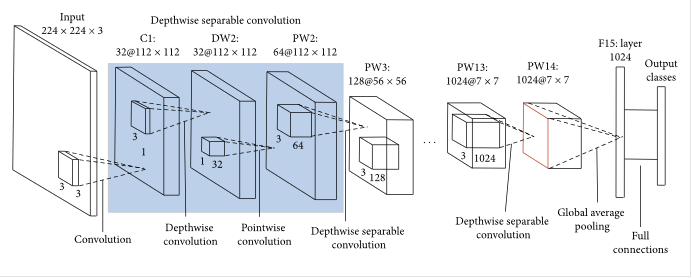

In [ ]:
base_model = tf.keras.applications.MobileNet(
    input_shape=(img_size[0], img_size[1], 3),
    include_top=False,
    weights='imagenet')

base_model.summary()


## 4.2. Classificador Específico (TAREFA 3)

Pesquise como utilizar um modelo base. Nesse caso já foi baixado o modelo do MobileNet na secção 4.1.

Descubra como fazer para preservar os pesos já treinados e acrecentar uma nova camada final FC para classificação com os dados específicos.

Dica: Para conectar a saida do modelo base com o restante das camadas que irá criar utilize GlobalAveragePooling2D(). É possível resolver essa questão com 3 camadas finais depois desse pooling.

In [ ]:
model = tf.keras.Sequential([
##### Crie aqui seu modelo aproveitando o modelo base já treinado
])

model.summary()

# 5. Treinamento

## 5.1. Configuração

In [ ]:
epochs = 10

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss_function = tf.keras.losses.BinaryCrossentropy()

model.compile(optimizer=opt, loss=loss_function)

## 5.2. Execução (ATENÇÃO)

In [ ]:
log = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

In [ ]:
losses = log.history["loss"]
val_losses = log.history["val_loss"]

data_epochs = np.arange(0, epochs, 1)
plt.plot(data_epochs, losses, color="yellow", lw=5, label = 'Training Loss')
plt.plot(data_epochs, val_losses, color="red", lw=5, label = 'Validation Loss')

plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

In [ ]:
eval_loss = model.evaluate(X_test, Y_test, batch_size=batch_size)

print(f"Accuracy: {1-eval_loss}")

## 5.3. Fine Tuning (TAREFA 4)

Perceba que o resultado anterir não foi ainda tão satisfatório e com muito overfit.

Isso ocorre porque o modelo base não foi ajustado para os dataset específico. Para isso vamos fazer um leve ajuste de apenas 2 rodas de treinamento.

Entretanto, dessa vez vamos descongelar os pesos antes de treinar.Pode usar as mesmas configurações de otmização e loss. Inclusive os mesmos dados de treino.

In [ ]:
epochs=2

####### configure e compile o novo treinamento aqui

In [ ]:
eval_loss = model.evaluate(X_test, Y_test, batch_size=batch_size)

print(f"Accuracy: {1-eval_loss}")

# 6. Testes

## 6.1. Amostras Aleatórias

In [ ]:
s = random.randint(0, len(X_test)-1)

images = X_test[s:s+12]
labels = Y_test[s:s+12]

predictions = model.predict(images)

print(predictions.shape)
print(predictions)

n = 6
plt.figure(figsize=(20, 5))

for i in range(n):

    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i])
    actual =  labels[i]

    if predictions[i] > 0.5:
        predicted = 1
        confidence = round(predictions[i][0]*100,2)
    else:
        predicted = 0
        confidence = round((1-predictions[i][0])*100,2)


    if actual == predicted:
        plt.title(f'Label: {predicted} ({confidence}%)', fontsize=10, color='green')
    else:
        plt.title(f'Label: {predicted} ({confidence}%)', fontsize=10, color='red')

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(images[i+n])
    actual =  labels[i]

    if predictions[i] > 0.5:
        predicted = 1
        confidence = round(predictions[i][0]*100,2)
    else:
        predicted = 0
        confidence = round((1-predictions[i][0])*100,2)

    if actual == predicted:
        plt.title(f'Label: {predicted} ({confidence}%)', fontsize=10, color='green')
    else:
        plt.title(f'Label: {predicted} ({confidence}%)', fontsize=10, color='red')

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()